In [1]:
# if using Colab
try:
    import google.colab
    is_colab = True
    wdir = 'https://raw.githubusercontent.com/ruggieris/DD/main/'
    # create folder src if it does not exists
    !mkdir -p src
    !mkdir -p data
    # download source
    !wget --no-cache --backups=1 -O src/dd.py {wdir}'src/dd.py'
    # download dataset
    !wget --no-cache --backups=1 -O src/dd.py {wdir}'data/ACSIncome_v1.pckl'
except:
    is_colab = False
    wdir = '' # local files
print('Working dir: ', wdir)

Working dir:  


In [2]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if is_colab:
    !pip install pyroaring
    !pip install pyfim 
    !pip install lightgbm
    !pip install fairlearn

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('src/' if is_colab else '../src/') # local path
import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=10)
plt.rc('legend', fontsize=10)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [4]:
# read ACSIncome data (see notebook generate_dataset_ACSIncome_v1)
df, decode = pickle.load(open('../data/ACSIncome_v1.pckl', 'rb'))
# state names
states = decode['STATE'].values()
# pretty printing long labels
pretty_rac1p = ['White', 'Black', 'Indian', 'Alaskian', 'Alaskian-Indian', 'Asian', 'Hawaiian', 'Other', 'Two+']
decode['RAC1P'] = { (i+1):pretty_rac1p[i] for i in range(len(pretty_rac1p)) }
# change to True to binarize RAC1P
if False: 
    census["RAC1P"][census["RAC1P"]!='White'] = 'Not White'

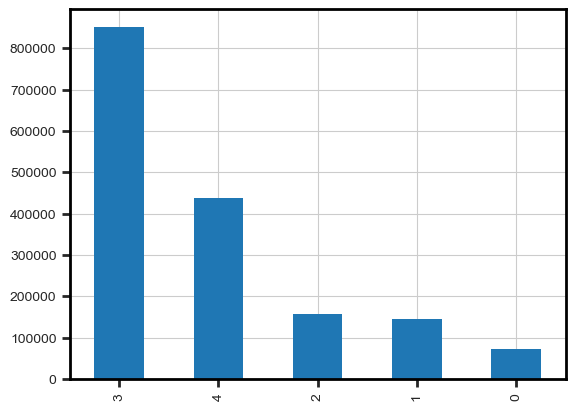

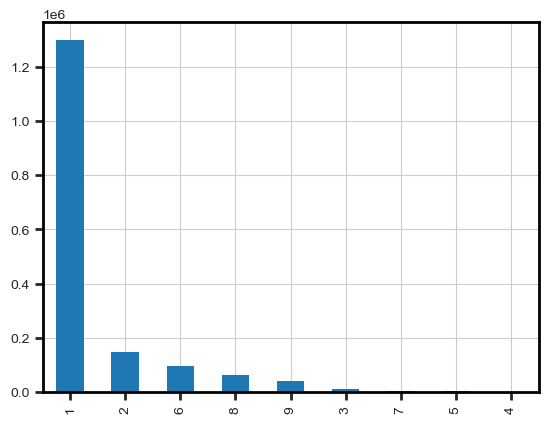

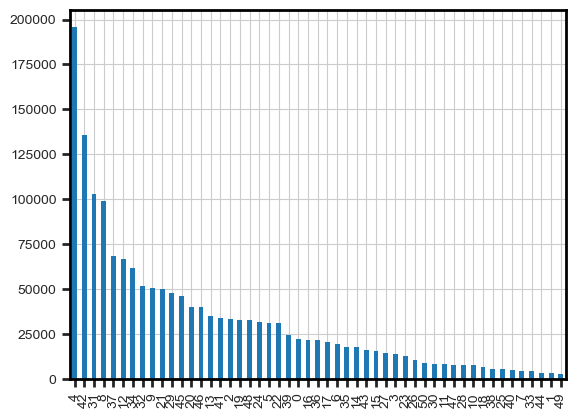

In [5]:
# distributions
df["WKHPgroup"].value_counts().plot(kind='bar')
plt.show()
df["RAC1P"].value_counts().plot(kind='bar')
plt.show()
df["STATE"].value_counts().plot(kind='bar')
plt.show()

In [6]:
# there are no missing values (strictly not required for DD)
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
WKHP         0
SEX          0
RAC1P        0
STATE        0
class        0
AGEPgroup    0
OCCPgroup    0
POBPgroup    0
WKHPgroup    0
dtype: int64

In [7]:
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup
0,18,1,18,5,4720,13,21,2,2,0,0,0,16,0,1
1,53,5,17,5,3605,18,40,1,1,0,0,3,11,0,3
2,41,1,16,5,7330,1,40,1,1,0,0,1,21,0,3
3,18,6,18,5,2722,1,2,2,1,0,0,0,9,0,0
4,21,5,19,5,3870,12,50,1,1,0,0,0,12,0,4


In [8]:
# predictive attributes (for models)
pred_atts = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'WKHP', 'SEX', 'RAC1P', 'STATE']
pred_all = pred_atts + ['class']
# nominal attributes (for DD)
disc_atts = ['AGEPgroup', 'COW', 'SCHL', 'MAR', 'OCCPgroup', 'POBPgroup', 'WKHPgroup', 'SEX', 'RAC1P', 'STATE']
disc_all = disc_atts + ['class']

# split train test
X = df[pred_atts]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.33, random_state=42)

In [9]:
# training model and make predictions - replace with your favorite classifier
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
y_pred_b = clf.predict(X_test)
df_test['pred_b'] = y_pred_b
decode['pred_b'] = decode['class']
df_test.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup,pred_b
517717,28,1,18,5,4700,37,50,2,1,12,0,0,16,0,4,0
319156,56,5,18,3,4230,36,40,1,2,6,0,3,14,0,3,0
507501,23,1,21,5,1430,36,40,1,1,12,1,0,4,0,3,0
537835,33,1,21,1,4710,17,50,2,1,12,1,1,16,0,4,1
305930,38,1,24,1,3250,34,40,2,1,6,1,1,10,0,3,1


### Independence metrics: how much discrimination in the predictions?

In [10]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(df_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White', predBadItem='pred_b=<=50K', valuedecode=decode)    
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
            |pred_b=<=50K|pred_b=>50K|      
RAC1P!=White|       89545|      31340|120885
RAC1P=White |      265953|     162447|428400
            |      355498|     193787|549285
RD = 0.119940
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_b=<=50K|pred_b=>50K|      
RAC1P=Black|       38778|       9741| 48519
RAC1P=White|      265953|     162447|428400
           |      304731|     172188|476919
RD = 0.178428
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_b=<=50K|pred_b=>50K|      
RAC1P=Two+ |       10089|       3751| 13840
RAC1P=White|      265953|     162447|428400
           |      276042|     166198|442240
RD = 0.108169
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_b=<=50K|pred_b=>50K|      
RAC1P=Asian|       17295|      14522| 31817
RAC1P=White|      265953|     162447|428400
           |      283248|     176969|460217
RD = -0.077228
-----
Context ALL
Size = 549285  Perc = 100

### Independence metrics: how much discrimination in the ground truth (perfect model)?

In [11]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_gt = dd.DD(df_test[disc_all], unprotectedItem='RAC1P=White', predBadItem='class=<=50K', valuedecode=decode)   
# all protected vs unprotected
ctg = disc_gt.ctg_any()
disc_gt.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_gt.ctg_global():
    disc_gt.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
            |class=<=50K|class=>50K|      
RAC1P!=White|      85449|     35436|120885
RAC1P=White |     261497|    166903|428400
            |     346946|    202339|549285
RD = 0.096458
-----
Context ALL
Size = 549285  Perc = 100.00%
           |class=<=50K|class=>50K|      
RAC1P=Black|      36568|     11951| 48519
RAC1P=White|     261497|    166903|428400
           |     298065|    178854|476919
RD = 0.143280
-----
Context ALL
Size = 549285  Perc = 100.00%
           |class=<=50K|class=>50K|      
RAC1P=Two+ |       9720|      4120| 13840
RAC1P=White|     261497|    166903|428400
           |     271217|    171023|442240
RD = 0.091908
-----
Context ALL
Size = 549285  Perc = 100.00%
           |class=<=50K|class=>50K|      
RAC1P=Asian|      17520|     14297| 31817
RAC1P=White|     261497|    166903|428400
           |     279017|    181200|460217
RD = -0.059755
-----
Context ALL
Size = 549285  Perc = 100.00%
           |class=<=50K|cla

In [12]:
m_gt = dict()
m_b = dict()
for ctg in disc_gt.ctg_global():
    _, pr = disc_gt.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_gt[pro] = ctg.rd()
    m_b[pro] = disc_b.ctg_rel(ctg).rd()

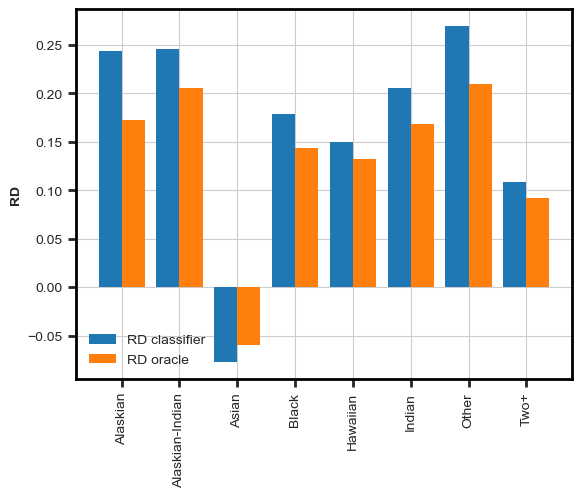

In [13]:
sorted_rac1p = sorted(pretty_rac1p[1:]) # White removed
X_axis = np.arange(len(sorted_rac1p))
plt.bar(X_axis - 0.2, [m_b[pro] for pro in sorted_rac1p], 0.4, label='RD classifier')
plt.bar(X_axis + 0.2, [m_gt[pro] for pro in sorted_rac1p], 0.4, label='RD oracle')
plt.xticks(X_axis, sorted_rac1p)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

### Independence metrics: discovering discrimination in predictions

In [14]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== pred.bad === pred.good === 
     protected       a            b       n1()
     unprotected     c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
def check_rd(ctg):
    # at least 20 protected
    return ctg.rd() if ctg.a >= 20 and ctg.n2() > 0 else None

def check_rr(ctg):
    # at least 20 protected 
    return ctg.rr() if ctg.a >= 20 and ctg.n2() > 0 else None

In [15]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = top k contingency tables
ctgs_rd = disc_b.extract(testCond=check_rd, minSupp=-100, topk=1000)
ctgs_rr = disc_b.extract(testCond=check_rr, minSupp=-100, topk=1000)

In [16]:
# top 3 wrt RD
for v, ctg in ctgs_rd[:3]:
    disc_b.print(ctg)
    print("RD = {:f}".format(v))

-----
Context STATE=HI AND POBPgroup=Asia AND MAR=Married AND class=<=50K AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 142  Perc = 0.03%
           |pred_b=<=50K|pred_b=>50K|   
RAC1P=Asian|         127|         10|137
RAC1P=White|           0|          1|  1
           |         127|         11|138
RD = 0.927007
-----
Context STATE=HI AND POBPgroup=Asia AND MAR=Married AND class=<=50K
Size = 186  Perc = 0.03%
           |pred_b=<=50K|pred_b=>50K|   
RAC1P=Asian|         160|         19|179
RAC1P=White|           0|          2|  2
           |         160|         21|181
RD = 0.893855
-----
Context STATE=HI AND POBPgroup=Asia AND WKHPgroup=31-40 AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 126  Perc = 0.02%
           |pred_b=<=50K|pred_b=>50K|   
RAC1P=Asian|          97|         23|120
RAC1P=White|           0|      

In [17]:
# top 3 wrt RR
for v, ctg in ctgs_rr[:3]:
    disc_b.print(ctg)
    print("RR = {:f}".format(v))

-----
Context POBPgroup=Africa AND WKHPgroup=>40 AND class=>50K AND SEX=Male AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 167  Perc = 0.03%
           |pred_b=<=50K|pred_b=>50K|   
RAC1P=Black|          23|         55| 78
RAC1P=White|           1|         79| 80
           |          24|        134|158
RR = 23.589744
-----
Context POBPgroup=Africa AND AGEPgroup=41-50 AND WKHPgroup=>40 AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 120  Perc = 0.02%
           |pred_b=<=50K|pred_b=>50K|   
RAC1P=Black|          33|         38| 71
RAC1P=White|           0|         41| 41
           |          33|         79|112
RR = 19.521127
-----
Context POBPgroup=Africa AND SCHL=Bachelor's degree AND WKHPgroup=>40 AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,

In [18]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

236

Text(0, 0.5, 'p2')

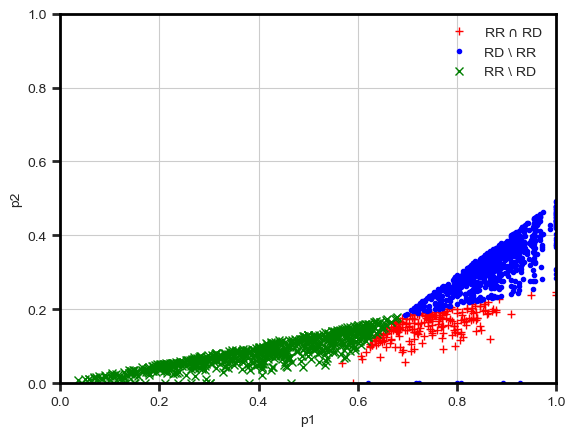

In [19]:
# plot p1() vs p2() for top-k contingency tables
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

### Independence metrics: fair-classifier

In [20]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="demographic_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P'], random_state=42).astype(int)
df_test['pred_a'] = y_pred_a
# extend decode
decode['pred_a'] = decode['class']

In [21]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(df_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White', predBadItem='pred_a=<=50K', valuedecode=decode)  
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
            |pred_b=<=50K|pred_b=>50K|      
RAC1P!=White|       74956|      45929|120885
RAC1P=White |      266075|     162325|428400
            |      341031|     208254|549285
RD = -0.001030
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_a=<=50K|pred_a=>50K|      
RAC1P=Black|       30095|      18424| 48519
RAC1P=White|      266075|     162325|428400
           |      296170|     180749|476919
RD = -0.000818
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_a=<=50K|pred_a=>50K|      
RAC1P=Two+ |        8517|       5323| 13840
RAC1P=White|      266075|     162325|428400
           |      274592|     167648|442240
RD = -0.005700
-----
Context ALL
Size = 549285  Perc = 100.00%
           |pred_a=<=50K|pred_a=>50K|      
RAC1P=Asian|       19760|      12057| 31817
RAC1P=White|      266075|     162325|428400
           |      285835|     174382|460217
RD = -0.000038
-----
Context ALL
Size = 549285  Perc = 

In [22]:
m_a = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_a[pro] = ctg.rd()

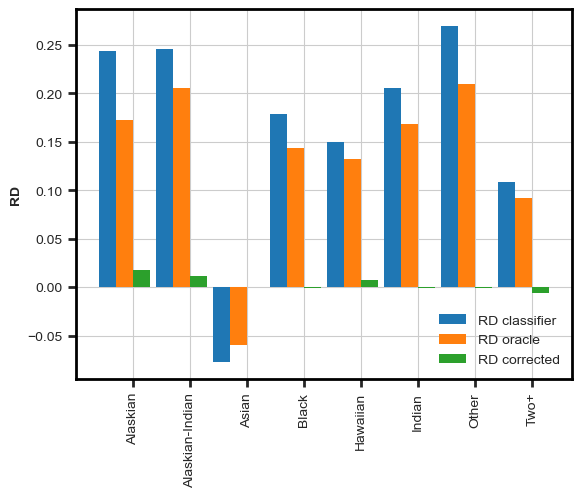

In [23]:
sorted_rac1p = sorted(pretty_rac1p[1:]) # White removed
X_axis = np.arange(len(sorted_rac1p))
plt.bar(X_axis - 0.45, [m_b[pro] for pro in sorted_rac1p], 0.3, label='RD classifier')
plt.bar(X_axis - 0.15, [m_gt[pro] for pro in sorted_rac1p], 0.3, label='RD oracle')
plt.bar(X_axis + 0.15, [m_a[pro] for pro in sorted_rac1p], 0.3, label='RD corrected')
plt.xticks(X_axis, sorted_rac1p)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

In [24]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))

ACC classifier 0.821648142585361
ACC corrected 0.7955141684189446


### Separation metrics: how much discrimination in the predictions?

In [25]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(df_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_b=<=50K', trueBadItem='class=<=50K', valuedecode=decode)  
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White                                     RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|       77978|       7471| 85449     class=<=50K|      224261|      37236|261497
class=>50K |       11567|      23869| 35436     class=>50K |       41692|     125211|166903
           |       89545|      31340|120885                |      265953|     162447|428400
EOP = 0.076622
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black                                     RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|       33782|       2786| 36568     class=<=50K|      224261|      37236|261497
class=>50K |        4996|       6955| 11951     class=>50K |       41692|     125211|166903
           |       38778|       9741| 48519                |      265953|     162447|428400
EOP = 0.168243
-----
Context ALL

### Separation metrics: correcting the classifier

In [26]:
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P']).astype(int)
df_test['pred_a'] = y_pred_a
# extend decode
decode['pred_a'] = decode['class']

In [27]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(df_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_a=<=50K', trueBadItem='class=<=50K', valuedecode=decode)      
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White                                     RAC1P=White
           |pred_b=<=50K|pred_b=>50K|                      |pred_b=<=50K|pred_b=>50K|      
class=<=50K|       51961|      33488| 85449     class=<=50K|      224271|      37226|261497
class=>50K |        8919|      26517| 35436     class=>50K |       41706|     125197|166903
           |       60880|      60005|120885                |      265977|     162423|428400
EOP = 0.001812
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black                                     RAC1P=White
           |pred_a=<=50K|pred_a=>50K|                      |pred_a=<=50K|pred_a=>50K|      
class=<=50K|       20375|      16193| 36568     class=<=50K|      224271|      37226|261497
class=>50K |        3013|       8938| 11951     class=>50K |       41706|     125197|166903
           |       23388|      25131| 48519                |      265977|     162423|428400
EOP = 0.002231
-----
Context ALL

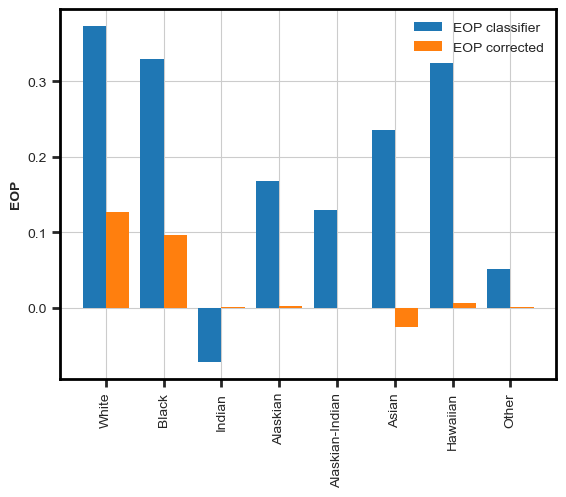

In [28]:
m_a = dict()
m_b = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_a[pro] = ctg.eop()
    m_b[pro] = disc_b.ctg_rel(ctg).eop()

plt.bar(X_axis - 0.2, [m_b[pro] for pro in sorted_rac1p], 0.4, label='EOP classifier')
plt.bar(X_axis + 0.2, [m_a[pro] for pro in sorted_rac1p], 0.4, label='EOP corrected')
plt.xticks(X_axis, pretty_rac1p[:-1])
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("EOP", fontweight="bold")
plt.show()

In [29]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))

ACC classifier 0.821648142585361
ACC corrected 0.7790964617639294
